In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime as dt
from IPython.display import clear_output

from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.linear_model import LogisticRegression as LR

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import tree # For visualizing the trees

# Because this is based on measuring distances between points...
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split as tts

# To visualize results for higher dimensional data
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# data
from sklearn.datasets import load_wine as lw


In [2]:
def DoKFold(model,X,y,k,scaler=None,random_state=146):
    from sklearn.model_selection import KFold
    import pandas as pd
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    # As we're doing the k fold validation, we'll keep track of training and testing scores
    train=[]
    test=[]
    # Make sure X is an array
    if type(X) == pd.core.frame.DataFrame:
        X = X.values
    for idxTrain,idxTest in kf.split(X):
        Xtrain = X[idxTrain,:]
        Xtest = X[idxTest,:]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        # If we want to rescale the data in any way, that should happen now:
        if scaler is not None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)
        # Now fit the model on the training data
        model.fit(Xtrain,ytrain)
        # Record the scores
        train.append(model.score(Xtrain,ytrain))
        test.append(model.score(Xtest,ytest))
    return train, test

def GetColors(N, cmap_name = 'rainbow'):
    from matplotlib.cm import get_cmap
    import numpy as np
    
    cmap = get_cmap(cmap_name)
    n = np.linspace(0,1,N)
    
    return cmap(n)

def PlotGroups(points, labels, colors):
    """ Inputs: 
            points: The array of points to plot
            labels: A list or array containing the label for each point
            colors: An array of colors, 1 per unique value in 'labels'
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize = (6,6))
    for i, yi in enumerate(np.unique(labels)):
        idx = (labels == yi)
        plt.scatter(points[idx,0], points[idx,1], 
                    color = colors[i], 
                    alpha=0.5,
                    ec = 'k', 
                    label = yi)
    plt.legend(bbox_to_anchor=[1,0.5], loc = 'center left')
    
    return

def CompareClasses(actual, predicted, names=None):
    classes = pd.DataFrame(columns=['Actual','Predicted'])
    classes['Predicted'] = predicted
    classes['Actual'] = actual
    conf_mat = pd.crosstab(index=classes['Actual'],
                           columns=classes['Predicted'])
    
    if names is not None: 
        conf_mat.columns = names
        conf_mat.index = names
    conf_mat.columns.name = 'Predicted'
    conf_mat.index.name = 'Actual'
    
    accuracy = sum(predicted==actual)/len(actual) #sums boolean t/f 
    return conf_mat, accuracy

## load in data

In [3]:
X = lw().data
y = lw().target
y_names = lw().target_names

## set aside 10% of the data as a validation set

In [4]:
X1, Xval, y1, yval = tts(X, y, shuffle=True, random_state=146, test_size=0.1)

## 1) Run logistic regression

In [5]:
# standardize data
ss = SS()
X1s = ss.fit_transform(X1)

log_reg = LR(random_state=146)
log_reg.fit(X1s, y1)

LogisticRegression(random_state=146)

In [6]:
log_reg.score(X1s,y1)

1.0

## 2) K-Fold & test data accuracy

In [7]:
k = 20
train, test = DoKFold(LR(),X1,y1,k,SS())

In [8]:
[np.mean(train), np.mean(test)]

[1.0, 0.98125]

## 3) K-nearest neighbors

In [84]:
# To find a suitable value for k, run a bunch of tests
k_range = np.arange(1,12,2)

# Choose k (for the k-fold)
n_folds = 20

# keep track of overall accuracy on training and testing sets
train = []
test = []

tStart = dt.now()
for k in k_range:
    clear_output()
    print('Testing k=',k)
    print(dt.now()-tStart)
    knn = KNN(n_neighbors=k)
    tr,te = DoKFold(knn,X1,y1,n_folds,SS())
    
    train.append(np.mean(tr))
    test.append(np.mean(te))
print('Done.',dt.now()-tStart)

Testing k= 11
0:00:00.869697
Done. 0:00:01.063164


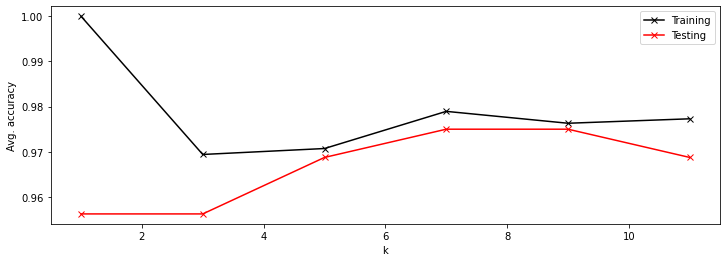

In [33]:
plt.figure(figsize=(12,4))
plt.plot(k_range,train,'-kx',label='Training')
plt.plot(k_range,test,'-rx',label='Testing')
plt.xlabel('k')
plt.ylabel('Avg. accuracy')
plt.legend()
plt.show()

In [85]:
idx_max = np.argmax(test)
[train[idx_max],test[idx_max],k_range[idx_max]]

[0.9789473684210526, 0.975, 7]

In [86]:
test

[0.95625, 0.95625, 0.96875, 0.975, 0.975, 0.96875]

In [87]:
train

[1.0,
 0.969407894736842,
 0.9707236842105262,
 0.9789473684210526,
 0.976315789473684,
 0.9773026315789473]

## 4) K-nearest neighbors (idw)

In [12]:
# To find a suitable value for k, run a bunch of tests
k_range = np.arange(1,12,2)

# Choose k (for the k-fold)
n_folds = 20

# keep track of overall accuracy on training and testing sets
train = []
test = []

tStart = dt.now()
for k in k_range:
    clear_output()
    print('Testing k=',k)
    print(dt.now()-tStart)
    knn = KNN(n_neighbors=k, weights='distance')
    tr,te = DoKFold(knn,X1,y1,n_folds,SS())
    
    train.append(np.mean(tr))
    test.append(np.mean(te))
print('Done.',dt.now()-tStart)

Testing k= 11
0:00:00.379492
Done. 0:00:00.469782


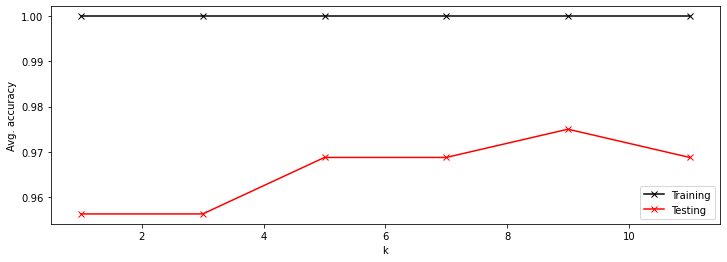

In [13]:
plt.figure(figsize=(12,4))
plt.plot(k_range,train,'-kx',label='Training')
plt.plot(k_range,test,'-rx',label='Testing')
plt.xlabel('k')
plt.ylabel('Avg. accuracy')
plt.legend()
plt.show()

In [14]:
idx_max = np.argmax(test)
[train[idx_max],test[idx_max],k_range[idx_max]]

[1.0, 0.975, 9]

## 5) Random forest

### Max_depth=2

In [15]:
# Determine how many trees we should have in the random forest
n_trees = [100,250,500]

# Choose k for the KFold validation
k = 20

train = []
test = []
tStart = dt.now()
for n in n_trees:
    clear_output()
    print('Testing n=',n)
    print(dt.now()-tStart)
    rfc = RFC(n_estimators=n,
              max_depth=2,
              max_features=None, 
              random_state=146)
    tr,te = DoKFold(rfc,X1,y1,k,SS())
    
    train.append(np.mean(tr))
    test.append(np.mean(te))
print('Done.', dt.now()-tStart)

Testing n= 500
0:00:29.292181
Done. 0:01:11.723312


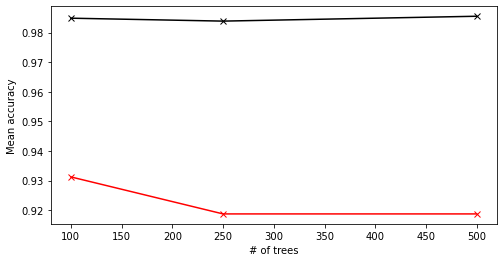

In [16]:
plt.figure(figsize=(8,4))
plt.plot(n_trees, train, '-xk', label='Training')
plt.plot(n_trees, test, '-xr', label='Testing')
plt.xlabel('# of trees')
plt.ylabel('Mean accuracy')
plt.show()

In [17]:
idx_max = np.argmax(test)
[train[idx_max],test[idx_max],n_trees[idx_max]]

[0.9848684210526315, 0.93125, 100]

### Max_depth=3

In [18]:
# Determine how many trees we should have in the random forest
n_trees = [100,250,500]

# Choose k for the KFold validation
k = 20

train = []
test = []
tStart = dt.now()
for n in n_trees:
    clear_output()
    print('Testing n=',n)
    print(dt.now()-tStart)
    rfc = RFC(n_estimators=n,
              max_depth=3,
              max_features=None, 
              random_state=146)
    tr,te = DoKFold(rfc,X1,y1,k,SS())
    
    train.append(np.mean(tr))
    test.append(np.mean(te))
print('Done.', dt.now()-tStart)

Testing n= 500
0:00:30.605861
Done. 0:01:15.725870


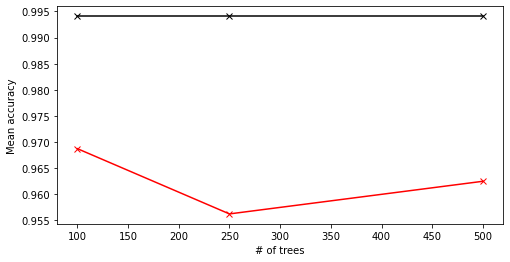

In [19]:
plt.figure(figsize=(8,4))
plt.plot(n_trees, train, '-xk', label='Training')
plt.plot(n_trees, test, '-xr', label='Testing')
plt.xlabel('# of trees')
plt.ylabel('Mean accuracy')
plt.show()

In [20]:
idx_max = np.argmax(test)
[train[idx_max],test[idx_max],n_trees[idx_max]]

[0.9940789473684211, 0.96875, 100]

### max_depth=4

In [40]:
# Determine how many trees we should have in the random forest
n_trees = [100,250,500]

# Choose k for the KFold validation
k = 20

train = []
test = []
tStart = dt.now()
for n in n_trees:
    clear_output()
    print('Testing n=',n)
    print(dt.now()-tStart)
    rfc = RFC(n_estimators=n,
              max_depth=4,
              max_features=None, 
              random_state=146)
    tr,te = DoKFold(rfc,X1,y1,k,SS())
    
    train.append(np.mean(tr))
    test.append(np.mean(te))
print('Done.', dt.now()-tStart)

Testing n= 500
0:00:31.254611
Done. 0:01:15.435628


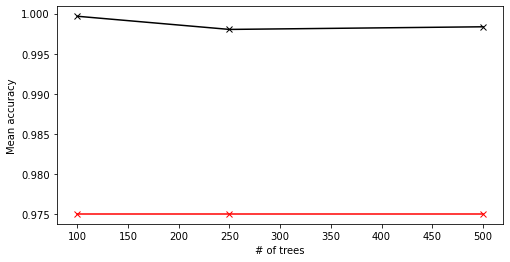

In [41]:
plt.figure(figsize=(8,4))
plt.plot(n_trees, train, '-xk', label='Training')
plt.plot(n_trees, test, '-xr', label='Testing')
plt.xlabel('# of trees')
plt.ylabel('Mean accuracy')
plt.show()

In [42]:
idx_max = np.argmax(test)
[train[idx_max],test[idx_max],n_trees[idx_max]]

[0.999671052631579, 0.975, 100]

In [43]:
train

[0.999671052631579, 0.9980263157894737, 0.9983552631578947]

In [44]:
test

[0.975, 0.975, 0.975]

### max_depth=5

In [24]:
# Determine how many trees we should have in the random forest
n_trees = [100,250,500]

# Choose k for the KFold validation
k = 20

train = []
test = []
tStart = dt.now()
for n in n_trees:
    clear_output()
    print('Testing n=',n)
    print(dt.now()-tStart)
    rfc = RFC(n_estimators=n,
              max_depth=5,
              max_features=None, 
              random_state=146)
    tr,te = DoKFold(rfc,X1,y1,k,SS())
    
    train.append(np.mean(tr))
    test.append(np.mean(te))
print('Done.', dt.now()-tStart)

Testing n= 500
0:00:31.480388
Done. 0:01:15.682957


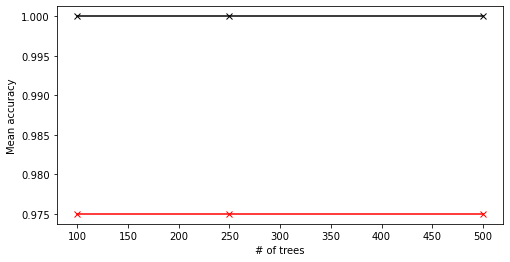

In [25]:
plt.figure(figsize=(8,4))
plt.plot(n_trees, train, '-xk', label='Training')
plt.plot(n_trees, test, '-xr', label='Testing')
plt.xlabel('# of trees')
plt.ylabel('Mean accuracy')
plt.show()

In [26]:
idx_max = np.argmax(test)
[train[idx_max],test[idx_max],n_trees[idx_max]]

[1.0, 0.975, 100]

In [76]:
# Determine how many trees we should have in the random forest
n_trees = [100,250,500]

# Choose k for the KFold validation
k = 20
depths = [2,3,4,5]
train = []
test = []
tStart = dt.now()
for n in n_trees:
    clear_output()
    print('Testing n=',n)
    print(dt.now()-tStart)
    for d in depths: 
        rfc = RFC(n_estimators=n,
                  max_depth=d, 
                  random_state=146)
        tr,te = DoKFold(rfc,X1,y1,k,SS())
    
        train.append(np.mean(tr))
        test.append(np.mean(te))
print('Done.', dt.now()-tStart)

Testing n= 500
0:01:42.856553
Done. 0:04:08.080793


In [77]:
test

[0.975,
 0.96875,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975]

In [78]:
train

[0.9828947368421052,
 0.9986842105263157,
 1.0,
 1.0,
 0.9828947368421052,
 1.0,
 1.0,
 1.0,
 0.9819078947368419,
 0.999671052631579,
 1.0,
 1.0]

### random forest results:
max_depth=2
[0.9848684210526315, 0.93125, 100]

max_depth=3
[0.9940789473684211, 0.96875, 100]

max_depth=4
[0.999671052631579, 0.975, 100]

max_depth=5
[1.0, 0.975, 100]

For all tested n_trees, 100 trees yielded the most accurate results. Choosing model with max_depth=4 because it has the most accurate test scores while not being as overfit and a simpler model than max_depth=5. Max_depth=3 is even less overfit and is closer to max_depth=4's accuracy results, but if choosing purely based on highest test accuracy, go with 4. 

## 7) Compare results from logistic regression, best KNN model, and best random forest

logistic regression: [1.0, 0.98125]

KNN(uniform weight): [0.9789473684210526, 0.975, 7]

random forest: [0.999671052631579, 0.975, 100]

**KNN and random forest** yielded identical test accuracy scores. **Logistic regression** had the highest avg. test accuracy score, but appears to be overfit.

# 8) Testing all models on the validation data set


In [27]:
ss = SS()
X1s = ss.fit_transform(X1)
Xval_s = ss.transform(Xval)

## Logistic regression

In [28]:
log_reg.fit(X1s, y1)
log_reg.score(Xval_s, yval)

1.0

## KNN (uniform)

In [51]:
knn = KNN(n_neighbors=9)
knn.fit(X1s,y1)
knn.score(Xval_s,yval)

0.9444444444444444

## Random forest

In [80]:
# Determine how many trees we should have in the random forest
n_trees = [100,250,500]
#n_trees = [500]
# Choose k for the KFold validation
k = 20
depths = [2,3,4,5]
train = []
test = []
tStart = dt.now()
for n in n_trees:
    clear_output()
    print('Testing n=',n)
    print(dt.now()-tStart)
    for d in depths: 
        rfc = RFC(n_estimators=n,
                  max_depth=d, 
                  random_state=146)
        tr,te = DoKFold(rfc,X1,y1,k,SS())
    
        train.append(np.mean(tr))
        test.append(np.mean(te))
print('Done.', dt.now()-tStart)

Testing n= 500
0:00:31.762723
Done. 0:01:16.338554


In [81]:
test

[0.975,
 0.96875,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975]

In [82]:
train

[0.9828947368421052,
 0.9986842105263157,
 1.0,
 1.0,
 0.9828947368421052,
 1.0,
 1.0,
 1.0,
 0.9819078947368419,
 0.999671052631579,
 1.0,
 1.0]

In [ ]:
rfc = RFC(n_estimators=500, max_depth=2, random_state=146)
rfc.fit(X1s,y1)
rfc.score(Xval_s,yval)